In [91]:
import time
import numpy as np
import dxchange
from utils import nor_phase
from ganrec2 import GANphase
import os
from lib import visualize
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from ganrec1 import *
import skimage.io as io
import quantities as pq
from skimage.transform import resize


# Propagation of Thomas's spheres

The ground truth of the phase and the sphere are taken from Thomas's simulation. They are then normalized according to the specification of Ganrec. I have also done resizing.

In [73]:

simulation_attenuation = '/beegfs/desy/user/jentscht/for_dawit/groundtruth/fresnel_with_supersampling_double_sphere_30000_eV/ground_truth_projection/ground_truth_projection_attenuation_30000_eV_00061_type_float32_8192x8192.tif'
simulation_phase = '/beegfs/desy/user/jentscht/for_dawit/groundtruth/fresnel_with_supersampling_double_sphere_30000_eV/ground_truth_projection/ground_truth_projection_phase_30000_eV_00061_type_float32_8192x8192.tif'

phase_image = resize(dxchange.read_tiff(simulation_phase), (512, 512))
attenuation_image = resize(dxchange.read_tiff(simulation_attenuation), (512, 512))

phase_image = nor_phase(phase_image)/np.max(nor_phase(phase_image))
attenuation_image = nor_phase(attenuation_image)/np.max(nor_phase(attenuation_image))
# resize_factor = 0.25
# phase_image = resize(phase_image, (int(phase_image.shape[0] * resize_factor), int(phase_image.shape[1] * resize_factor)))
# attenuation_image = resize(attenuation_image, (int(attenuation_image.shape[0] * resize_factor), int(attenuation_image.shape[1] * resize_factor)))
# visualize([phase_image, attenuation_image])
energy = 30.8 * pq.keV
lam = wavelength_from_energy(energy)
fresnel_nummber = 0.005 * pq.dimensionless
z = 1.0 * pq.meter
pv = np.sqrt(fresnel_nummber * lam * z) #array(8.39314161e-06) * m
px, py = phase_image.shape

kwargs = {
    'iter_num': 1000,
    'internal_iter': 3,
    'last_retrieval': False,
    'save_wpath': 'data/gan_phase/spheres/',
    'init_wpath': 'data/gan_phase/spheres/',
    'init_model': False,
    'save_model': False,
    'filter_type': 'median', #chose from median, contrast, noise, diffuse, phase_only, alternate
    'output_num': 2,
    'phase_only': False,
    'recon_monitor': True,
}

kwargs.update({
    'energy': energy.magnitude,
    'z': z.magnitude,
    'pv': pv.magnitude,
    'idx': 0,
    'abs_ratio': 0.1,
    'px': px,
    'py': py,
})


given_phase = phase_image
cos, sin = np.cos(given_phase), np.sin(given_phase)
given_absorption = (1 - attenuation_image) * kwargs['abs_ratio']
given_absorption = resize(given_absorption, (px, py))

different_distances = list(np.arange(0, kwargs['z'], 0.03))
# ffs = [ffactor(px * 2, py *2, kwargs['energy'], distance, kwargs['pv']) for distance in different_distances]
ffs = ffactors(px * 2, py *2, kwargs['energy'], different_distances, kwargs['pv'])
propagated_images = [nor_phase(phase_fresnel(given_phase, given_absorption, ffs[i], px)) for i in range(len(ffs))]

visualize([propagated_images[1][0,:,:,0].numpy(), propagated_images[10][0,:,:,0].numpy(), propagated_images[20][0,:,:,0].numpy()])



# Run GanRec to get the phase of the Sphere

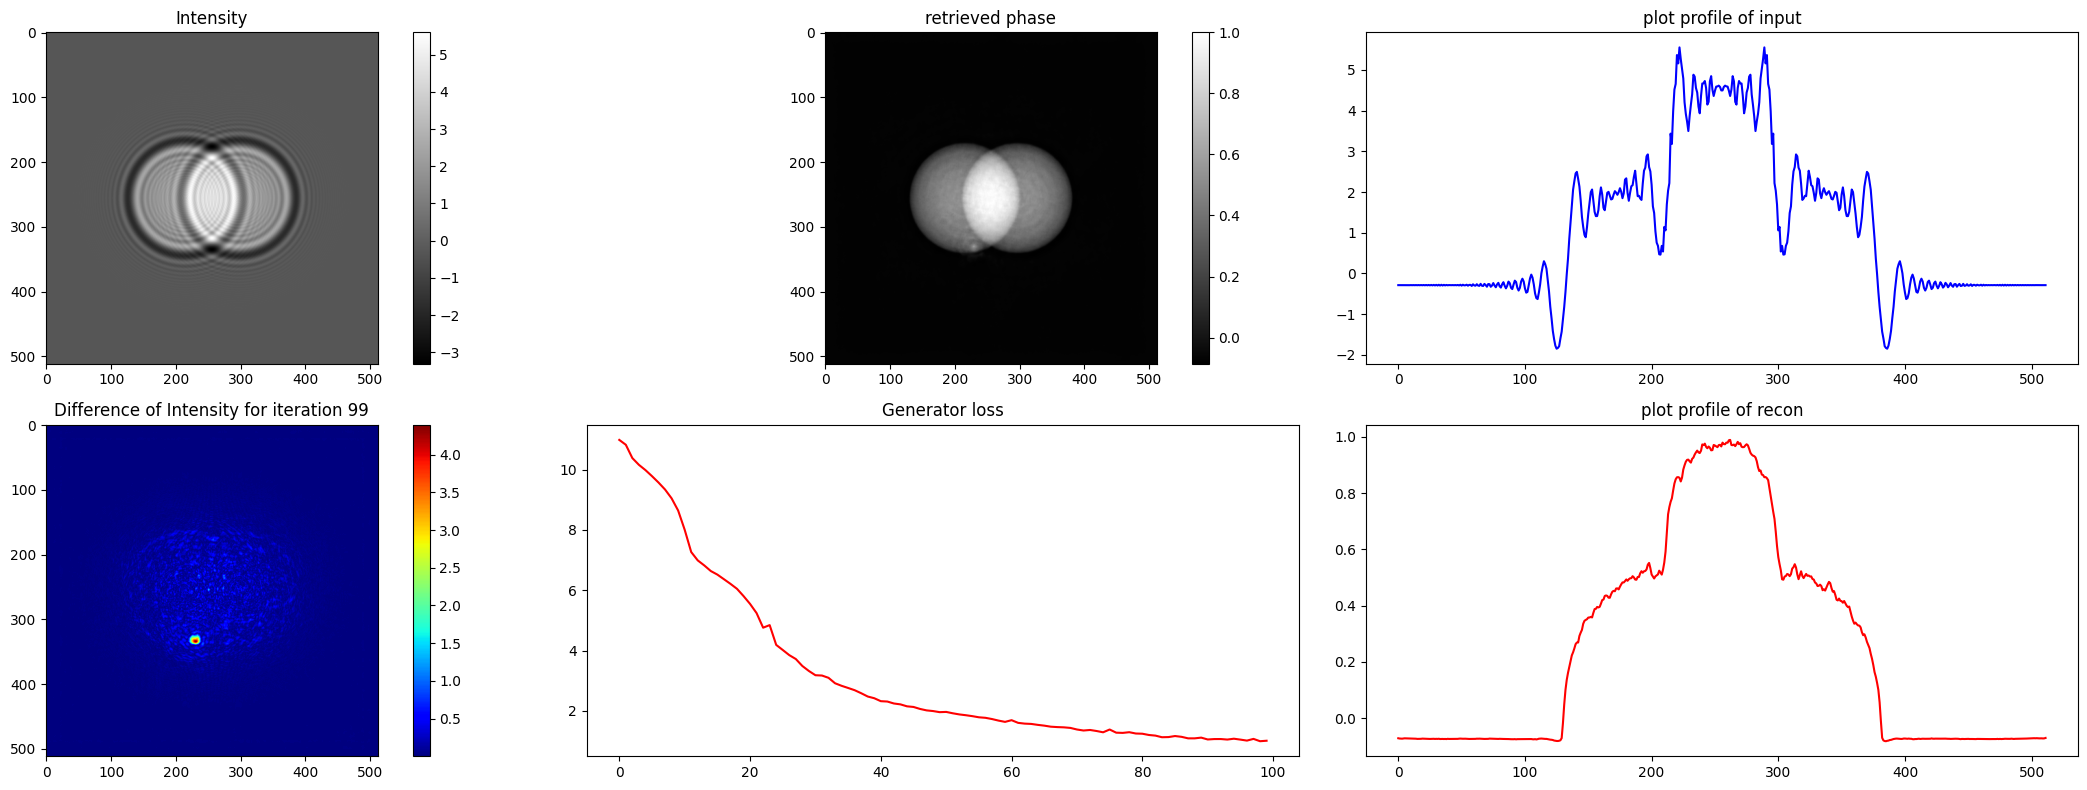

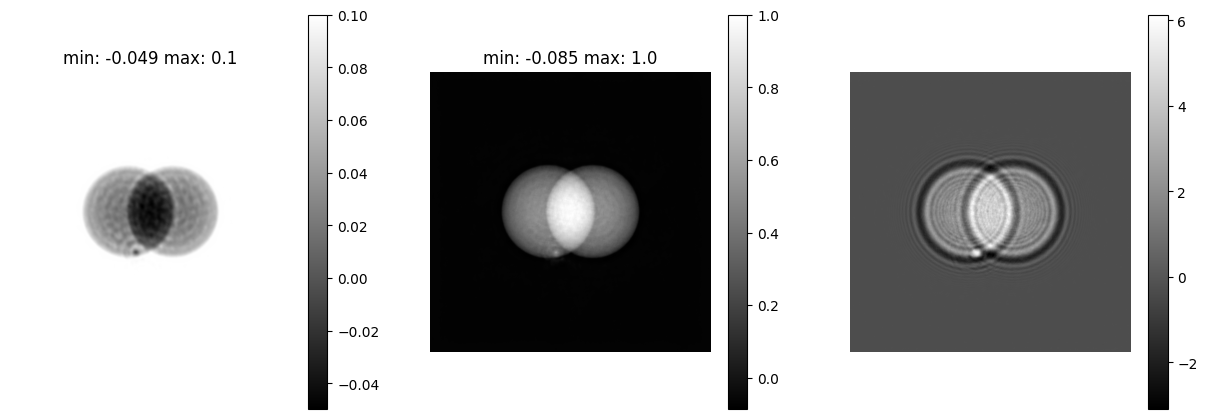

                                                                0
experiment_name                                spider_hair_61_0.1
iter                                                          100
sum of pointwise difference                              -0.00026
sum of absolute value of pointwise difference           22.797415
sum of squared difference                                7.496381
PSNR                                                  [18.344181]
SSIM                                                  [0.8685831]
NRMSE                                                    2.737952
MSSIM                                                 [0.9537046]
epoch_time                                             388.641087
total_time                                             388.641087


In [82]:
from ganrec_dataloader import measure_reconstruction_quality, tf_reshape
idx = 61
abs_ratio = kwargs['abs_ratio']
kwargs['iter_num'] = 100
gan_phase_object = GANphase(propagated_images[-1][0,:,:,0], **kwargs)
start = time.time()
absorption, phase,propagated, loss, side_propagation  = gan_phase_object.recon
end = time.time()
time_count = end - start
visualize([absorption, phase, propagated])#, matched, data[idx], idx, abs_ratio, kwargs['iter_num'])
# io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/phase/phase_'+str(idx)+'_'+str(abs_ratio)+'.tif', phase[i])
# io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])
# io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/propagated/propagated_'+str(idx)+'_'+str(abs_ratio)+'.tif', propagated[i])
df = measure_reconstruction_quality(img1= tf_reshape(propagated), img2 = tf_reshape(propagated_images[-1][0,:,:,0]), experiment_name = 'spider_hair_'+str(idx)+'_'+str(abs_ratio), csv_file = 'Vojtech_fixed.csv', iteration = kwargs['iter_num'], save = True, epoch_time = time_count, total_time = np.sum(time_count))
# display(df)


# Save the phase as a video

In [90]:
save_as_video(side_propagation, px, py, 'spherical_propagated_images.mp4')

100 (1, 512, 512, 2) <dtype: 'float32'>
(100, 1, 512, 512, 2) <dtype: 'float32'>


ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/beegfs/desy/user/hailudaw/anacon/envs/tf --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpost

# Direct plot of the mean, std, min, max of the phase after output of the last layer

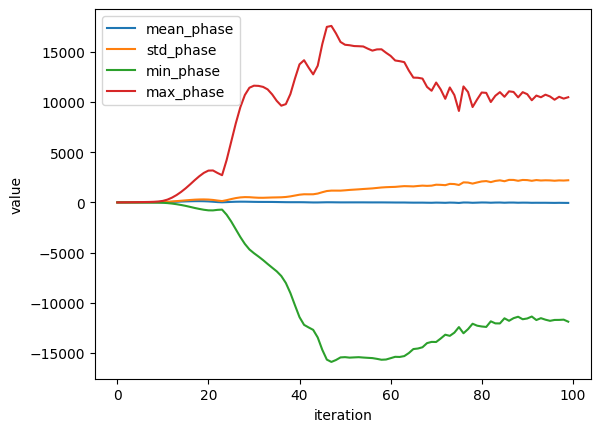

In [113]:
#using pandas, analyze the mean, std, min, max of the side propagation
import pandas as pd
analysis = pd.DataFrame({'experiment', 'iteration', 'mean_phase', 'std_phase', 'min_phasee', 'max_phase', 'mean_abs', 'std_abs', 'min_abs', 'max_abs'})
side_propagations = side_propagation
for iter in range(len(side_propagations)):
    #fill the values in the dataframe
    new_pd = pd.DataFrame(columns=['iteration', 'mean_phase', 'std_phase', 'min_phase', 'max_phase'])
    new_pd['iteration'] = [iter]
    new_pd['mean_phase'] = [tf.math.reduce_mean(side_propagations[iter]).numpy()]
    new_pd['std_phase'] = [tf.math.reduce_std(side_propagations[iter]).numpy()]
    new_pd['min_phase'] = [tf.math.reduce_min(side_propagations[iter]).numpy()]
    new_pd['max_phase'] = [tf.math.reduce_max(side_propagations[iter]).numpy()]
    analysis = pd.concat([analysis, new_pd])
analysis.drop(analysis.columns[0], axis=1, inplace=True)
analysis.dropna(inplace=True)
analysis.to_csv('data/gan_phase/spider_abs_ratio/analysis.csv')

#graph the mean, std, min, max of the side propagation
import matplotlib.pyplot as plt
plt.figure()
plt.plot(analysis['iteration'], analysis['mean_phase'], label='mean_phase')
plt.plot(analysis['iteration'], analysis['std_phase'], label='std_phase')
plt.plot(analysis['iteration'], analysis['min_phase'], label='min_phase')
plt.plot(analysis['iteration'], analysis['max_phase'], label='max_phase')
plt.legend()
plt.xlabel('iteration')
plt.ylabel('value')
plt.savefig('sphere_analysis.png')

# Plot after normalization


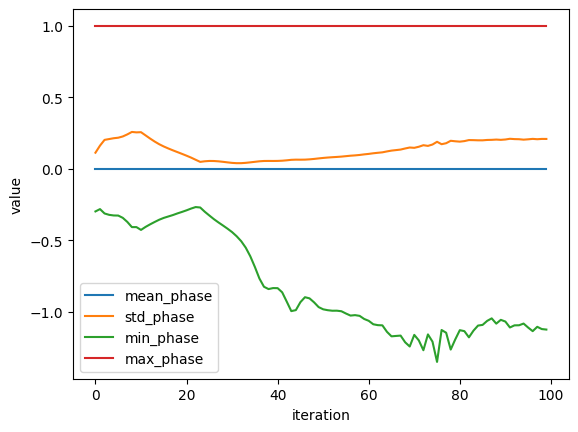

In [114]:
#using pandas, analyze the mean, std, min, max of the side propagation
import pandas as pd
analysis = pd.DataFrame({'experiment', 'iteration', 'mean_phase', 'std_phase', 'min_phasee', 'max_phase', 'mean_abs', 'std_abs', 'min_abs', 'max_abs'})
side_propagations = side_propagation
for iter in range(len(side_propagations)):
    #fill the values in the dataframe
    new_pd = pd.DataFrame(columns=['iteration', 'mean_phase', 'std_phase', 'min_phase', 'max_phase'])
    new_pd['iteration'] = [iter]
    new_pd['mean_phase'] = [tf.math.reduce_mean(tfnor_phase(side_propagations[iter])).numpy()]
    new_pd['std_phase'] = [tf.math.reduce_std(tfnor_phase(side_propagations[iter])).numpy()]
    new_pd['min_phase'] = [tf.math.reduce_min(tfnor_phase(side_propagations[iter])).numpy()]
    new_pd['max_phase'] = [tf.math.reduce_max(tfnor_phase(side_propagations[iter])).numpy()]
    analysis = pd.concat([analysis, new_pd])
analysis.drop(analysis.columns[0], axis=1, inplace=True)
analysis.dropna(inplace=True)
analysis.to_csv('data/gan_phase/spider_abs_ratio/analysis.csv')

#graph the mean, std, min, max of the side propagation
import matplotlib.pyplot as plt
plt.figure()
plt.plot(analysis['iteration'], analysis['mean_phase'], label='mean_phase')
plt.plot(analysis['iteration'], analysis['std_phase'], label='std_phase')
plt.plot(analysis['iteration'], analysis['min_phase'], label='min_phase')
plt.plot(analysis['iteration'], analysis['max_phase'], label='max_phase')
plt.legend()
plt.xlabel('iteration')
plt.ylabel('value')
plt.savefig('sphere_analysis.png')

# The different between the normalized grouth truth phase and the retrieved phase

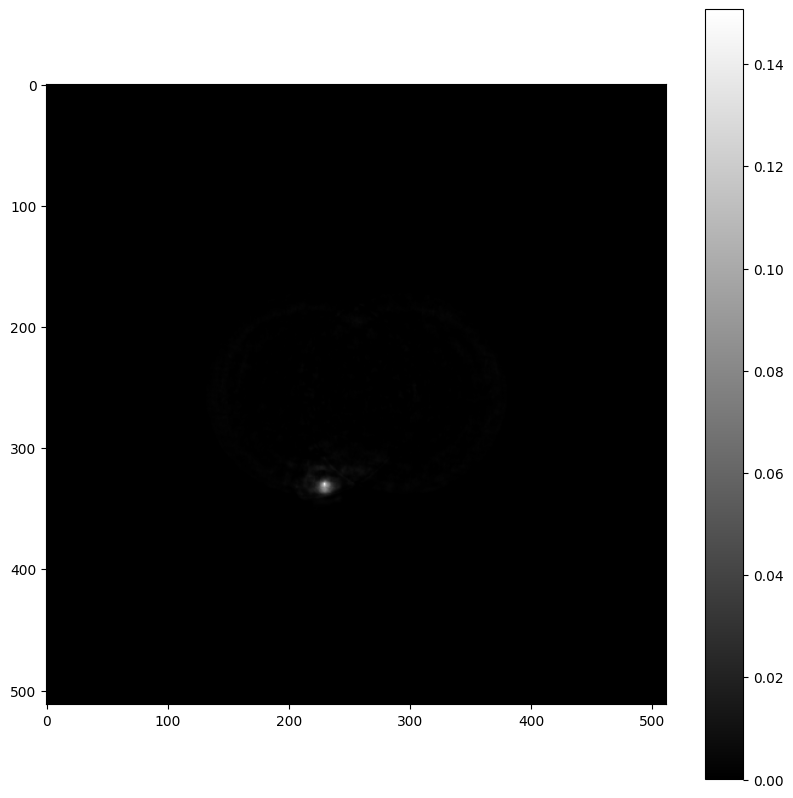

In [119]:
visualize([(phase - given_phase)**2])

# Qualitative analysis between the two

In [120]:
measure_reconstruction_quality(tf_reshape(phase), tf_reshape(given_phase), experiment_name = 'sphere'+str(idx)+'_'+str(abs_ratio), csv_file = '', iteration = kwargs['iter_num'], save = False, epoch_time = time_count, total_time = np.sum(time_count))

                                                          0
experiment_name                                sphere61_0.1
iter                                                    100
sum of pointwise difference                       -0.000002
sum of absolute value of pointwise difference      2.848366
sum of squared difference                          0.074738
PSNR                                             [38.35726]
SSIM                                           [0.98792195]
NRMSE                                              0.273383
MSSIM                                          [0.99235076]
epoch_time                                       388.641087
total_time                                       388.641087


,0
experiment_name,sphere61_0.1
iter,100
sum of pointwise difference,-0.000002
sum of absolute value of pointwise difference,2.848366
sum of squared difference,0.074738
PSNR,[38.35726]
SSIM,[0.98792195]
NRMSE,0.273383
MSSIM,[0.99235076]
epoch_time,388.641087
